# Kichstarter Challenge



## Set-up and Import

In [192]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timezone
import json

# Libraries for data import
import os
import glob

# Preprocessing
#from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer


# Define a plotting style to be used for all plots in this notebook
plt.style.use('tableau-colorblind10')

We will import the data from the database using sqlalchemy. After we imported the data we can directly save it as a .csv file so we don't have to run the query every time we want to execute the notebook.

In [193]:
df = pd.read_csv('data/df_cleaned_for_ML.csv')

In [194]:
df.head()

,backers_count,category,country,created_at,deadline,id,is_starrable,launched_at,staff_pick,state,...,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer,percent_pledged
0,47,games,US,2017-08-02 16:28:13,2017-09-09 19:00:59,928751314,False,2017-08-10 19:00:59,False,successful,...,8,1,10,9,8,9,19,19,41.49,195.00
1,271,music,US,2012-09-30 08:45:33,2013-06-12 07:03:15,928014092,False,2013-05-13 07:03:15,False,successful,...,17,1,13,12,5,6,7,7,82.67,149.36
2,3,games,GB,2017-01-07 10:11:11,2017-03-13 18:22:56,596091328,False,2017-01-12 19:22:56,False,failed,...,5,1,12,13,1,3,19,18,55.13,1.36
3,3,publishing,US,2012-12-06 19:04:31,2013-01-09 21:32:07,998516049,False,2012-12-10 21:32:07,False,successful,...,4,1,10,9,12,1,21,21,940.00,100.71
4,35,music,US,2014-10-24 19:35:50,2015-05-02 04:25:46,1224600291,False,2015-04-02 04:25:46,False,successful,...,22,0,2,2,4,5,4,4,106.43,106.43


In [178]:
df.dtypes

backers_count                int64
category                    object
country                     object
created_at                  object
deadline                    object
id                           int64
is_starrable                  bool
launched_at                 object
staff_pick                    bool
state                       object
usd_pledged                float64
blurb_length                 int64
sub_category                object
usd_goal                   float64
name_length                  int64
creation_to_launch_days      int64
campaign_days                int64
launch_day                   int64
deadline_day                 int64
launch_month                 int64
deadline_month               int64
launch_time                  int64
deadline_time                int64
pledge_per_backer          float64
percent_pledged            float64
dtype: object

## The Data
Before starting to build and train a model we have to explore and maybe also clean the data. 

In [195]:
#Print the shape of the data
print('Kickstarter dataset')
print('==================')
print('# observations: {}'.format(df.shape[0]))
print('# features:     {}'.format(df.shape[1]-1))

Kickstarter dataset
# observations: 192664
# features:     24


As we can see, the dataset contains 768 observations and 9 columns from which the last column defines the label, i.e. the test result. 
Thus, we have 8 independent features.

Let us take a look at the single variables included in the dataset:

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192664 entries, 0 to 192663
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   backers_count            192664 non-null  int64  
 1   category                 192664 non-null  object 
 2   country                  192664 non-null  object 
 3   created_at               192664 non-null  object 
 4   deadline                 192664 non-null  object 
 5   id                       192664 non-null  int64  
 6   is_starrable             192664 non-null  bool   
 7   launched_at              192664 non-null  object 
 8   staff_pick               192664 non-null  bool   
 9   state                    192664 non-null  object 
 10  usd_pledged              192664 non-null  float64
 11  blurb_length             192664 non-null  int64  
 12  sub_category             192664 non-null  object 
 13  usd_goal                 192664 non-null  float64
 14  name

In [181]:
df.describe()

,backers_count,id,usd_pledged,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer,percent_pledged
count,192664.000000,1.926640e+05,1.926640e+05,192664.000000,1.926640e+05,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,1.926640e+05
mean,152.563463,1.072715e+09,1.351672e+04,18.894781,3.778767e+04,5.767502,8.513988,5.835730,15.207781,15.205731,6.442667,6.734569,13.313167,12.238363,74.424624,5.131338e+02
std,898.347455,6.195476e+08,8.918397e+04,5.011409,1.065709e+06,2.705023,7.658024,7.772306,8.870334,9.072131,3.358092,3.373498,7.384585,7.593188,136.621628,2.531355e+04
min,0.000000,8.624000e+03,0.000000e+00,0.000000,1.000000e-02,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,4.000000,5.347017e+08,1.500000e+02,16.000000,1.500000e+03,4.000000,2.000000,1.000000,8.000000,7.000000,4.000000,4.000000,6.000000,5.000000,22.750000,3.640000e+00
50%,30.000000,1.074132e+09,1.772000e+03,20.000000,5.000000e+03,6.000000,6.000000,1.000000,15.000000,15.000000,7.000000,7.000000,16.000000,14.000000,47.710000,1.030000e+02
75%,94.250000,1.608192e+09,7.096622e+03,22.000000,1.244704e+04,8.000000,13.000000,10.000000,23.000000,23.000000,9.000000,10.000000,19.000000,19.000000,86.200000,1.288000e+02
max,105857.000000,2.147476e+09,8.596475e+06,35.000000,1.523501e+08,27.000000,30.000000,30.000000,31.000000,31.000000,12.000000,12.000000,23.000000,23.000000,10000.000000,6.876410e+06


In [182]:
df.isnull().sum()

backers_count              0
category                   0
country                    0
created_at                 0
deadline                   0
id                         0
is_starrable               0
launched_at                0
staff_pick                 0
state                      0
usd_pledged                0
blurb_length               0
sub_category               0
usd_goal                   0
name_length                0
creation_to_launch_days    0
campaign_days              0
launch_day                 0
deadline_day               0
launch_month               0
deadline_month             0
launch_time                0
deadline_time              0
pledge_per_backer          0
percent_pledged            0
dtype: int64

From the output above we could assume that the data is already rather clean with no missing values, but the summary we get with `.describe()` should make us wonder... We definitely have to check if in our case maybe missing values are represented by zeros. Before we have a closer look at the data and try to impute values, we will split our data into train and test set to make sure our test data will be not "contaminated" by information from the train data and vice versa.

In [196]:
# Dropping columns and creating new dataframe
df = df.drop(['id', 'backers_count', 'created_at', 'deadline', 'launched_at', 'usd_pledged', 'pledge_per_backer', 'percent_pledged', 'sub_category'], axis=1)
df.head()

,category,country,is_starrable,staff_pick,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
0,games,US,False,False,successful,22,1000.00,4,8,1,10,9,8,9,19,19
1,music,US,False,False,successful,15,15000.00,7,17,1,13,12,5,6,7,7
2,games,GB,False,False,failed,23,12160.66,8,5,1,12,13,1,3,19,18
3,publishing,US,False,False,successful,24,2800.00,7,4,1,10,9,12,1,21,21
4,music,US,False,False,successful,18,3500.00,4,22,0,2,2,4,5,4,4


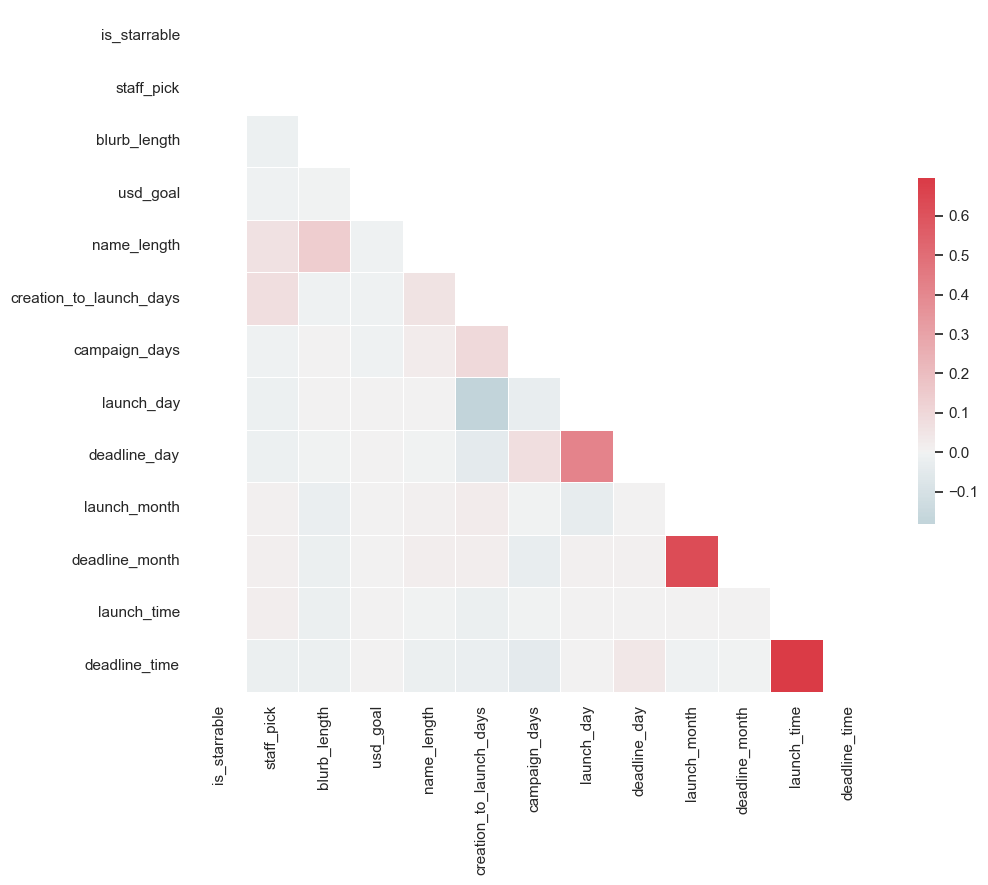

In [197]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df_transformed.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});


The dependent variable will now be converted into 1s (successful) and 0s (failure):

In [203]:
df['state'] = df['state'].replace({'failed': 0, 'successful': 1})

In [204]:
df.dtypes

category                    object
country                     object
is_starrable                object
staff_pick                  object
state                        int64
blurb_length                 int64
usd_goal                   float64
name_length                  int64
creation_to_launch_days      int64
campaign_days                int64
launch_day                   int64
deadline_day                 int64
launch_month                 int64
deadline_month               int64
launch_time                  int64
deadline_time                int64
dtype: object

In [205]:
df['staff_pick'] = df['staff_pick'].astype(str)
df['is_starrable'] = df['is_starrable'].astype(str)


In [209]:
df.head(5)

,category,country,is_starrable,staff_pick,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
0,games,US,False,False,1,22,1000.00,4,8,1,10,9,8,9,19,19
1,music,US,False,False,1,15,15000.00,7,17,1,13,12,5,6,7,7
2,games,GB,False,False,0,23,12160.66,8,5,1,12,13,1,3,19,18
3,publishing,US,False,False,1,24,2800.00,7,4,1,10,9,12,1,21,21
4,music,US,False,False,1,18,3500.00,4,22,0,2,2,4,5,4,4


In [210]:
# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(df.columns[df.dtypes==object])
cat_features

['category', 'country', 'is_starrable', 'staff_pick']

In [211]:
# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(df.columns[df.dtypes!=object])
num_features.remove('state')
num_features


['blurb_length',
 'usd_goal',
 'name_length',
 'creation_to_launch_days',
 'campaign_days',
 'launch_day',
 'deadline_day',
 'launch_month',
 'deadline_month',
 'launch_time',
 'deadline_time']

 # stop here

In [123]:
# df_transformed_features = df_transformed.drop(['state'], axis=1)

In [124]:
# df_transformed['state'].unique()

array([1, 0])

Categorical features will now be one-hot encoded:

In [125]:
# Converting boolean features to string to include them in one-hot encoding
# df_transformed_features['staff_pick'] = df_transformed_features['staff_pick'].astype(str)

In [126]:
# Creating dummy variables
# df_transformed_features = pd.get_dummies(df_transformed_features, drop_first=True)

In [127]:
# list(df_transformed_features.head(0))

['is_starrable',
 'blurb_length',
 'usd_goal',
 'name_length',
 'creation_to_launch_days',
 'campaign_days',
 'launch_day',
 'deadline_day',
 'launch_month',
 'deadline_month',
 'launch_time',
 'deadline_time',
 'category_comics',
 'category_crafts',
 'category_dance',
 'category_design',
 'category_fashion',
 'category_film & video',
 'category_food',
 'category_games',
 'category_journalism',
 'category_music',
 'category_photography',
 'category_publishing',
 'category_technology',
 'category_theater',
 'country_AU',
 'country_BE',
 'country_CA',
 'country_CH',
 'country_DE',
 'country_DK',
 'country_ES',
 'country_FR',
 'country_GB',
 'country_HK',
 'country_IE',
 'country_IT',
 'country_JP',
 'country_LU',
 'country_MX',
 'country_NL',
 'country_NO',
 'country_NZ',
 'country_SE',
 'country_SG',
 'country_US',
 'staff_pick_True']

Train-Test-Split

Let's split the data set into a training and test set. Using the training set and cross validation we will train our model and find the best hyperparameter combination. In the end the test set will be used for the final evaluation of our best model.

In [212]:
# Define predictors and target variable
X = df.drop('state', axis=1)
y = df['state']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 192664 observations in our dataset and 15 features
Our target vector has also 192664 values


In [216]:
# Split into train and test set 
RSEED =42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED, stratify=y)

In [217]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (144498, 15)
X_test shape: (48166, 15)
y_train shape: (144498,)
y_test shape: (48166,)


# Preprocessing Pipeline


Building a Pipeline always follows the same syntax. In our case we create one pipeline for our numerical features and one for our categorical features.

The missing values of the numerical features should be filled with the median value of the features and in the end, each feature should be scaled using the StandardScaler.

The missing values of the categorical features should be changed to "missing". In the end, we encode all categorical features as a one-hot numeric array.

In the end both pipelines are combined into one pipeline called "preprocessor" using ColumnTransformer from scikit-learn.

In [253]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# Set random seed 
RSEED = 42
warnings.filterwarnings("ignore")

In [245]:


# Pipline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [246]:
#from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Predictive Modelling using Pipelines and Grid Search
Logistic Regression

Now that we have a preprocessing pipeline we can add a model on top (this sequence will also be handled by a Pipeline) and see how it performs using cross validation.
In [ ]:


In [247]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [248]:
# Random Forests with default settings
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
                    ('pipe_rf', RandomForestClassifier())])
pipe_rf.fit(X_train, y_train)
print("Score:", round(pipe_rf.score(X_test, y_test),5))

Score: 0.7748


In [254]:
# XGBoost with default settings
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
                    ('pipe_xgb', xgb.XGBClassifier())])
pipe_xgb.fit(X_train, y_train)
print("Score:", round(pipe_xgb.score(X_test, y_test),5))

Score: 0.75427


In [255]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted_logreg = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)
y_train_predicted_rf = cross_val_predict(pipe_rf, X_train, y_train, cv=5)
y_train_predicted_xgb = cross_val_predict(pipe_xgb, X_train, y_train, cv=5)


In [256]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))
print("f1: {:.2f}".format(f1_score(y_train, y_train_predicted)))


Cross validation scores:
-------------------------
Accuracy: 0.72
Recall: 0.86
Precision: 0.73
f1: 0.79


In [259]:
accuracy_logreg = accuracy_score(y_train, y_train_predicted_logreg)
recall_logreg = recall_score(y_train, y_train_predicted_logreg)
precision_logreg = precision_score(y_train, y_train_predicted_logreg)
f1_logreg = f1_score(y_train, y_train_predicted_logreg)

accuracy_rf = accuracy_score(y_train, y_train_predicted_rf)
recall_rf = recall_score(y_train, y_train_predicted_rf)
precision_rf = precision_score(y_train, y_train_predicted_rf)
f1_rf = f1_score(y_train, y_train_predicted_rf)

accuracy_xgb = accuracy_score(y_train, y_train_predicted_xgb)
recall_xgb = recall_score(y_train, y_train_predicted_xgb)
precision_xgb = precision_score(y_train, y_train_predicted_xgb)
f1_xgb = f1_score(y_train, y_train_predicted_xgb)


In [260]:
validation_scores = pd.DataFrame([['model','accuracy','recall','precision','f1'],['logreg',accuracy_logreg, recall_logreg,precision_logreg,f1_logreg],['random_forest',accuracy_rf,recall_rf,precision_rf ,f1_rf],['xgboost',accuracy_xgb,recall_xgb,precision_xgb ,f1_xgb]])

In [261]:
validation_scores

,0,1,2,3,4
0,model,accuracy,recall,precision,f1
1,logreg,0.717837,0.85682,0.728317,0.78736
2,random_forest,0.766917,0.875572,0.77249,0.820807
3,xgboost,0.752834,0.858114,0.765064,0.808922


# Optimizing via Grid Search & Cross Validation
In order to optimize our model we will use gird search. At first we have to define a parameter space we want to search for the best parameter combination. Then we have to initiate our grid search via GridSearchCV. The last step is to use the fit method providing our training data as input.

In [273]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' infront of the corresponding hyperparameters. 
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='f1', 
                           verbose=5, n_jobs=-1)

In [274]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 2/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.7s
[CV 1/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.7s
[CV 3/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.7s
[CV 1/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.767 total time=   1.2s
[CV 4/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.769 total time=   1.2s
[CV 2/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.768 total time=   1.4s
[CV 5/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.766 total time=   1.4s
[CV 3/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.768 total time=   1.4s
[CV 5/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total tim

/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.776 total time= 1.4min
[CV 5/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.773 total time= 1.4min


/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.776 total time= 1.4min


/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.776 total time= 1.4min
[CV 3/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.773 total time= 1.4min
[CV 2/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.789 total time=  10.7s
[CV 3/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.787 total time=  11.4s
[CV 1/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.788 total time=  16.0s
[CV 1/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.5s
[CV 2/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.4s
[CV 5/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.787 total time=   5.3s
[CV 3/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.4s
[CV 4/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total t

/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.786 total time= 1.4min


/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.788 total time= 1.4min


/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.785 total time= 1.4min
[CV 4/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.788 total time= 1.4min


/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.786 total time= 1.3min


/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.788 total time= 1.3min


/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.785 total time= 1.2min


/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.789 total time=  53.4s


/Users/jensbimberg/NeueFische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.787 total time=  50.7s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['blurb_length',
                                                                          'usd_goal',
                                                                          'name_length',
                                                                          'creation_to_launch_days',
                                  

In [275]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best score:
0.79
Best parameters:
{'logreg__C': 10, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [276]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model = grid_logreg.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['blurb_length', 'usd_goal',
                                                   'name_length',
                                                   'creation_to_launch_days',
                                                   'campaign_days',
                                                   'launch_day', 'deadline_day',
                                                   'launch_month',
                                                   'deadline_month',
                                                 

# Final Evaluation

Finally we have a good model. Let's see if it also passes the final evaluation on the test data. Therefore we have to prepare the test set in the same way we did with the training data. Thanks to our pipeline it's done in a blink and we can be sure no data-leakage happened at any step through the whole data preprocessing.

When we saved the best model in the cell above, we did not only save the trained model but also the fitted preprocessing pipeline. Thus, transforming the test data the same way as the train data happens also when calling the .predict method on the best_model.

In [277]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))
print("f1: {:.2f}".format(f1_score(y_test, y_test_predicted)))

Accuracy: 0.72
Recall: 0.86
Precision: 0.73
f1: 0.79


In [278]:
y_train_predicted = best_model.predict(X_train)

accuracy_cvgridsearch = accuracy_score(y_train, y_train_predicted)
recall_cvgridsearch = recall_score(y_train, y_train_predicted)
precision_cvgridsearch = precision_score(y_train, y_train_predicted)
f1_cvgridsearch = f1_score(y_train, y_train_predicted)

In [279]:
validation_scores_X_train = pd.DataFrame([
                                  [accuracy_logreg, recall_logreg,precision_logreg,f1_logreg],
                                  [accuracy_cvgridsearch, recall_cvgridsearch,precision_cvgridsearch,f1_cvgridsearch],
                                  [accuracy_rf,recall_rf,precision_rf ,f1_rf],
                                  [accuracy_xgb,recall_xgb,precision_xgb ,f1_xgb]],
                                        columns= ['accuracy','recall','precision','f1']
                                        )
validation_scores_X_train.index = ['logreg','gridsearchCV_logreg','random_forest','xgboost']
validation_scores_X_train

,accuracy,recall,precision,f1
logreg,0.716896,0.857012,0.727286,0.786838
gridsearchCV_logreg,0.719408,0.858296,0.729339,0.788580
random_forest,0.746024,0.857080,0.757988,0.804494
xgboost,0.745920,0.847749,0.762201,0.802702


In [280]:
y_test_predicted = best_model.predict(X_test)
y_test_predicted_logreg = cross_val_predict(pipe_logreg, X_test, y_test, cv=5)
y_test_predicted_rf = cross_val_predict(pipe_rf, X_test, y_test, cv=5)
y_test_predicted_xgb = cross_val_predict(pipe_xgb, X_test, y_test, cv=5)

In [285]:
accuracy_logreg = accuracy_score(y_test, y_test_predicted_logreg)
recall_logreg = recall_score(y_test, y_test_predicted_logreg)
precision_logreg = precision_score(y_test, y_test_predicted_logreg)
f1_logreg = f1_score(y_test, y_test_predicted_logreg)

accuracy_rf = accuracy_score(y_test, y_test_predicted_rf)
recall_rf = recall_score(y_test, y_test_predicted_rf)
precision_rf = precision_score(y_test, y_test_predicted_rf)
f1_rf = f1_score(y_test, y_test_predicted_rf)

accuracy_xgb = accuracy_score(y_test, y_test_predicted_xgb)
recall_xgb = recall_score(y_test, y_test_predicted_xgb)
precision_xgb = precision_score(y_test, y_test_predicted_xgb)
f1_xgb = f1_score(y_test, y_test_predicted_xgb)

accuracy_cvgridsearch = accuracy_score(y_test, y_test_predicted)
recall_cvgridsearch = recall_score(y_test, y_test_predicted)
precision_cvgridsearch = precision_score(y_test, y_test_predicted)
f1_cvgridsearch = f1_score(y_test, y_test_predicted)

In [286]:
validation_scores_X_train = pd.DataFrame([
                                  [accuracy_logreg, recall_logreg,precision_logreg,f1_logreg],
                                  [accuracy_cvgridsearch, recall_cvgridsearch,precision_cvgridsearch,f1_cvgridsearch],
                                  [accuracy_rf,recall_rf,precision_rf ,f1_rf],
                                  [accuracy_xgb,recall_xgb,precision_xgb ,f1_xgb]],
                                        columns= ['accuracy','recall','precision','f1']
                                        )
validation_scores_X_train.index = ['logreg','gridsearchCV_logreg','random_forest','xgboost']
validation_scores_X_train

,accuracy,recall,precision,f1
logreg,0.716896,0.857012,0.727286,0.786838
gridsearchCV_logreg,0.719906,0.861336,0.728661,0.789463
random_forest,0.745505,0.855820,0.757993,0.803941
xgboost,0.745920,0.847749,0.762201,0.802702


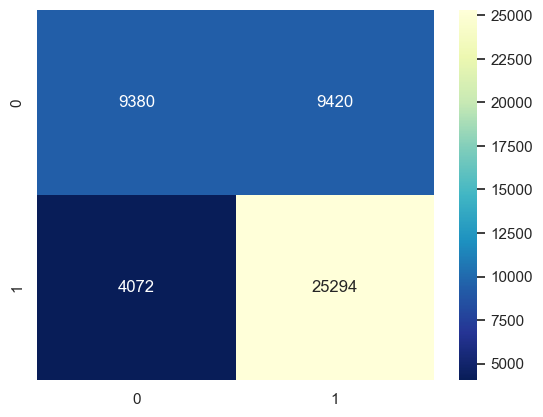

In [271]:
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

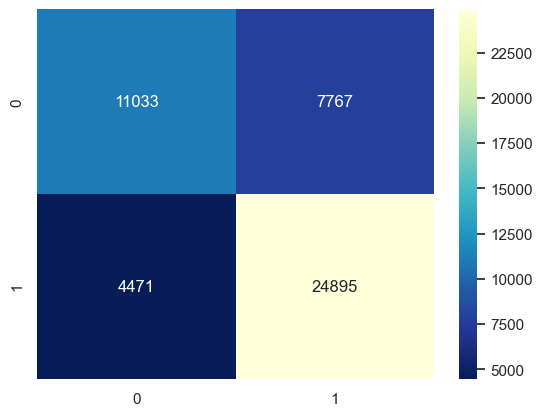

In [272]:
cm = confusion_matrix(y_test, y_test_predicted_xgb)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

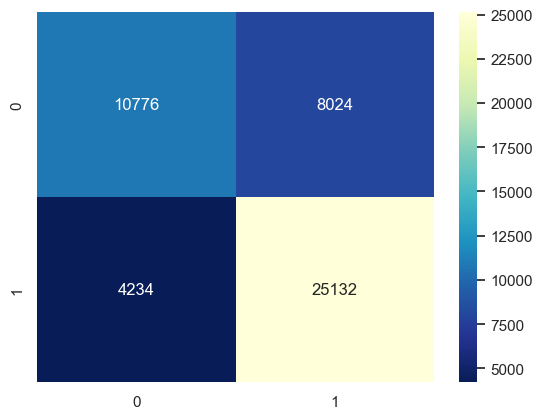

In [287]:
cm = confusion_matrix(y_test, y_test_predicted_rf)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

In [291]:
#simple model by campaign_days:
# df_pclass = pd.DataFrame(df['usd_goal'])
df_pclass = pd.DataFrame(X_test['usd_goal'])

base_model_pred = df_pclass.applymap(lambda x: 0 if x >= 4000   else 1)

base_model_pred

,usd_goal
141673,1
73410,0
91050,1
177006,0
91743,1
...,...
46000,1
25379,1
66211,1
158619,0


In [292]:
f1_basemodel = f1_score(y_test, base_model_pred)

In [293]:
f1_basemodel

0.6040598248932394

In [294]:
accuracy_base = accuracy_score(y_test, base_model_pred)
recall_base = recall_score(y_test, base_model_pred)
precision_base = precision_score(y_test, base_model_pred)
f1_base = f1_score(y_test, base_model_pred)

In [295]:
validation_scores_X_test = pd.DataFrame([
                                  [accuracy_base, recall_base,precision_base,f1_base],
                                  [accuracy_logreg, recall_logreg,precision_logreg,f1_logreg],
                                  [accuracy_cvgridsearch, recall_cvgridsearch,precision_cvgridsearch,f1_cvgridsearch],
                                  [accuracy_rf,recall_rf,precision_rf ,f1_rf],
                                  [accuracy_xgb,recall_xgb,precision_xgb ,f1_xgb]],
                                        columns= ['accuracy','recall','precision','f1']
                                        )
validation_scores_X_test.index = ['base model','logreg','gridsearchCV_logreg','random_forest','xgboost']
validation_scores_X_test

,accuracy,recall,precision,f1
base model,0.578437,0.527447,0.706712,0.604060
logreg,0.716896,0.857012,0.727286,0.786838
gridsearchCV_logreg,0.719906,0.861336,0.728661,0.789463
random_forest,0.745505,0.855820,0.757993,0.803941
xgboost,0.745920,0.847749,0.762201,0.802702


# models are ready.

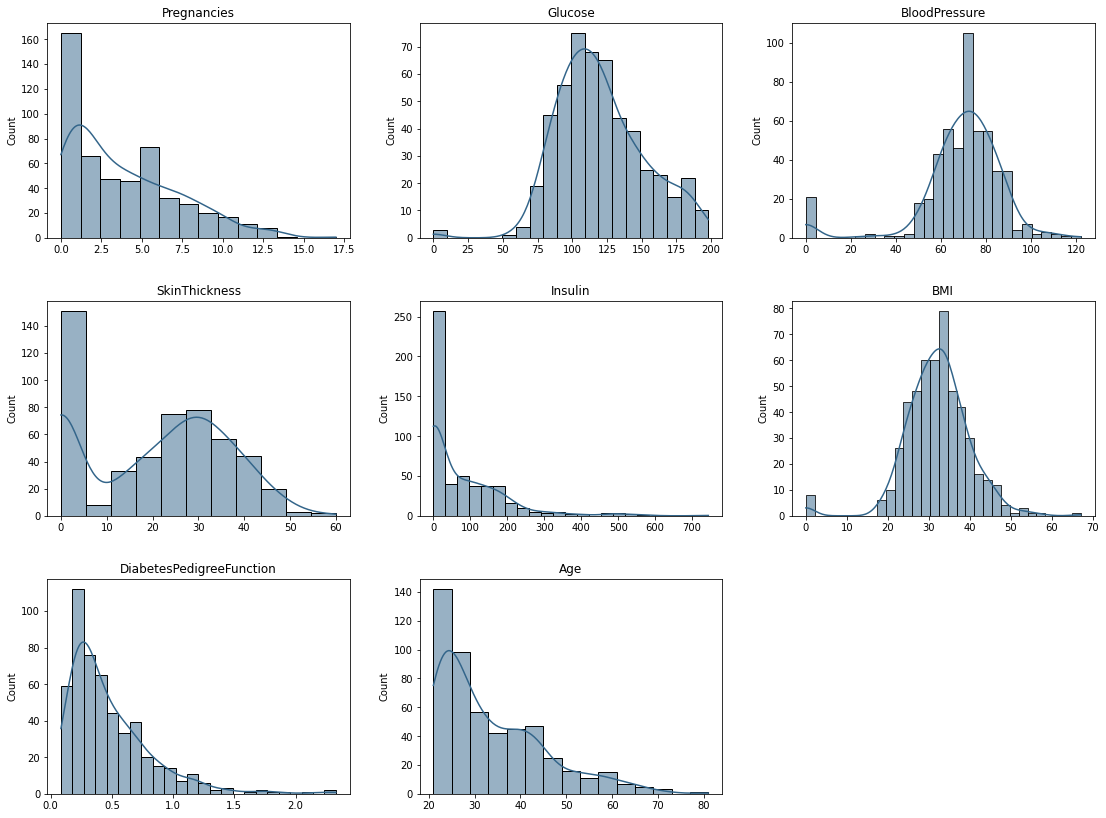

In [ ]:
# Plot distribution of features 
features = df_train.columns.tolist()
features.remove('Outcome')

fig,ax = plt.subplots(3,3,figsize=(16,12))
count = 0
for item in features:
    sns.histplot(df_train[item], kde=True, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
    count += 1
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

These plots clearly show several things:
* The distributions of `Pregnancies`, `Age`, `Insulin` and `DiabetesPedigreeFunction` are positively/right skewed. Transforming them might increase our model's performance (depending on the model type we use).
* The features `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` and `BMI` include zeros, even if it is not a expected value for those features. This might indicate, that missing values are represented as zeros in this dataset. We have to find a suitable strategy to replace/impute those values. 

### Analysis of Missing Values (== 0)

In [ ]:
# Replace zeros with np.nan
def replace_zeros(df, feature):
    df[feature] = df[feature].replace(0, np.nan)
    return df

columns_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in columns_with_zeros:
    df_train = replace_zeros(df_train, col)

In [ ]:
# Check for missing data
df_train.isnull().sum()

Pregnancies                   0
Glucose                       3
BloodPressure                21
SkinThickness               151
Insulin                     249
BMI                           8
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Insulin and SkinThickness have a lot of missing values. Let's start by looking at the columns with fewer missings and try to replace/drop them.

In [ ]:
print(df_train.query("BMI.isnull() & BloodPressure.isnull()").shape[0])
index_list = df_train.query("BMI.isnull() & BloodPressure.isnull()").index.tolist()
df_train.query("BMI.isnull() & BloodPressure.isnull()")

5


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
60,2,84.0,NaN,NaN,NaN,NaN,0.304,21,0
426,0,94.0,NaN,NaN,NaN,NaN,0.256,25,0
522,6,114.0,NaN,NaN,NaN,NaN,0.189,26,0
49,7,105.0,NaN,NaN,NaN,NaN,0.305,24,0
706,10,115.0,NaN,NaN,NaN,NaN,0.261,30,1


There are 5 observations with missing values in 4 of 8 features. We will drop those rows.

In [ ]:
# Drop rows by index
df_train = df_train.drop(index_list)

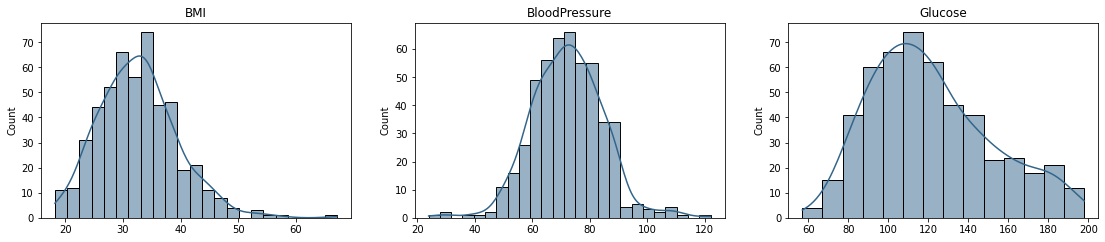

In [ ]:
# Plot distribution of numerical features with missing values 
plot_col = ['BMI', 'BloodPressure', 'Glucose']
fig,ax = plt.subplots(1, 3,figsize=(16,4))
count = 0
for col in plot_col:
    sns.histplot(df_train[col], kde=True, ax=ax[count], color='#33658A').set(title=col, xlabel='')
    #plt.axvlines(X_train[col].mean(), 0, X_train[col].max(), color="red")
    count += 1
fig.tight_layout(pad=3)

In [ ]:
# Print mean and median for those features
for col in plot_col:
    print(f"{col} mean: {df_train[col].mean().round(2)}")
    print(f"{col} median: {df_train[col].median().round(2)}")

BMI mean: 32.66
BMI median: 32.4
BloodPressure mean: 72.3
BloodPressure median: 72.0
Glucose mean: 121.4
Glucose median: 117.0


For a first try, we will replace the missing values for those columns either with the mean or median. It makes sense to check the distribution to decide which value to choose. Comparing the mean and median for those columns shows, that both values for BMI and BloodPressure are pretty close together. Only the heavies skewed column Glucose shows a remarkable difference between mean and median. We will keep it simple and replace all missing values with the median of the respective features. 

In [ ]:
# Replace missing values with median of respective feature
values_dict = {}
for col in plot_col:
    values_dict[col] = df_train[col].median()
    df_train[col] = df_train[col].fillna(values_dict[col])

In [ ]:
# Check for missings again
df_train.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness               146
Insulin                     244
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [ ]:
print("SkinThickness % of missing data:", ((df_train.SkinThickness.isnull().sum()/df_train.shape[0])*100).round(2))
print("Insulin % of missing data:", ((df_train.Insulin.isnull().sum()/df_train.shape[0])*100).round(2))

SkinThickness % of missing data: 28.68
Insulin % of missing data: 47.94


There are still two columns where a high proportion of the data is missing. Replacing them with the mean or median might induce inaccuracies. We can have a look if there are other features, which are strongly correlated so that we can drop the ones with the missing values.

### Correlations

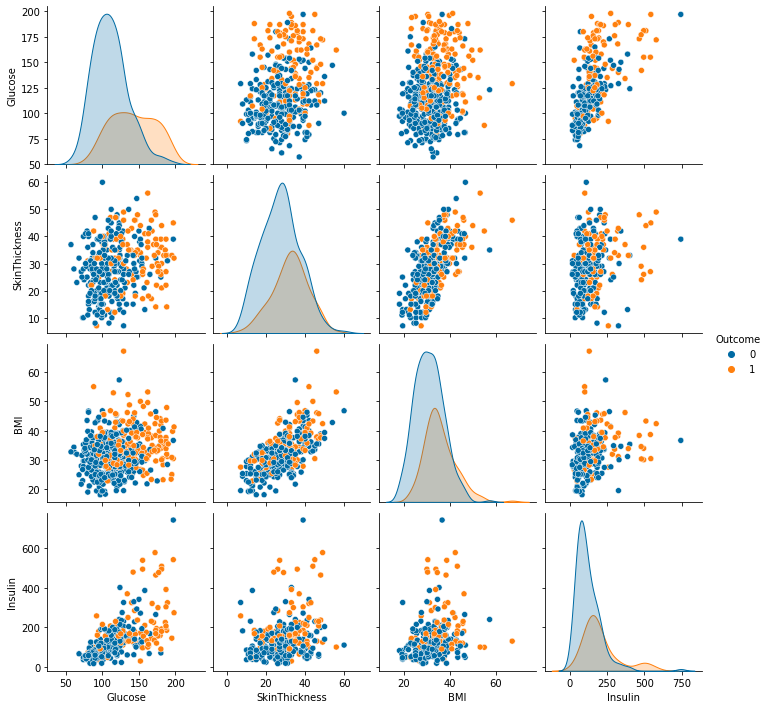

In [ ]:
sns.pairplot(df_train[["Glucose", "SkinThickness", "BMI", "Insulin", "Outcome"]], hue="Outcome");

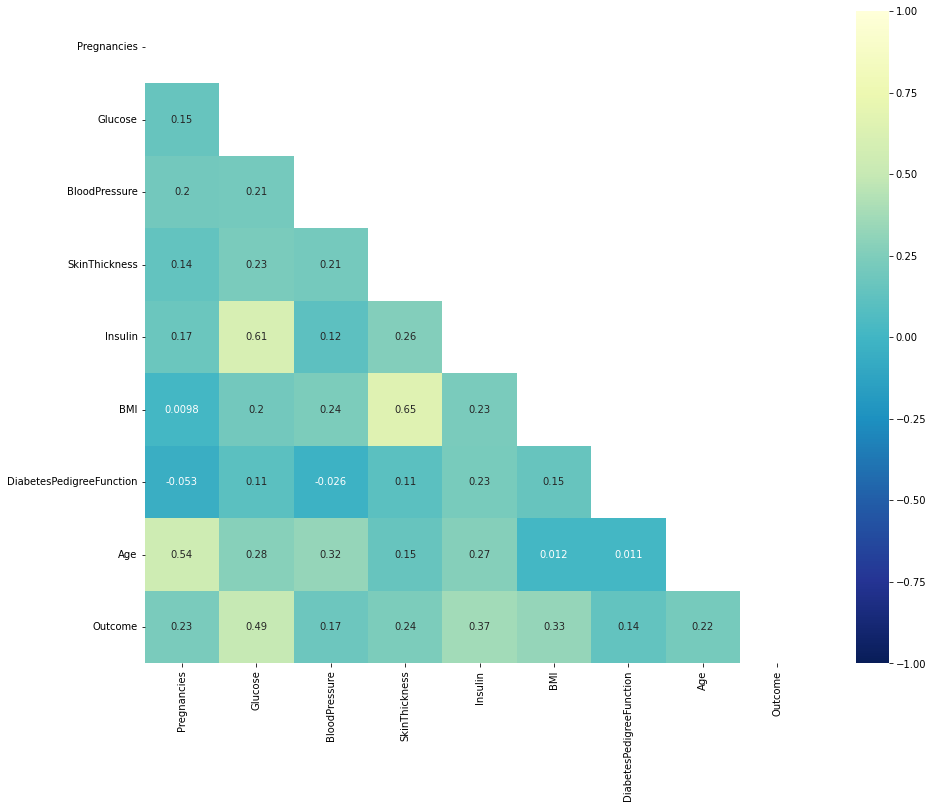

In [ ]:
# Calculate correlations between features
corr = df_train.corr()

plt.subplots(figsize=(15, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap="YlGnBu_r", mask=mask, vmax=1, vmin=-1);

From the pairplot and correlation heatmap above we can see that the features `BMI` and `SkinThickness` are rather highly correlated. The same applies for the features `Glucose` and `Insulin`. Since we have so many missing values for `SkinThickness` and `Insulin` we will drop them now.

In [ ]:
# Drop Insulin and SkinThickness column
df_train = df_train.drop(["Insulin", "SkinThickness"], axis=1)

In [ ]:
df_train.head(2)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
657,1,120.0,80.0,38.9,1.162,41,0
125,1,88.0,30.0,55.0,0.496,26,1


In [ ]:
# Check for missings AGAIN
df_train.isnull().sum().sum()

0

## Preparing the Test Set

We have replaced missing values and dropped some columns in our train data. We need to prepare our test data the same way to be able to make proper predictions. To fill in the missing values we will use the median we calculated on the training set and stored in `values_dict`.

In [ ]:
df_test.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
373,2,105,58,40,94,34.9,0.225,25,0
164,0,131,88,0,0,31.6,0.743,32,1


In [ ]:
# Convert zeros to nan values
for col in columns_with_zeros:
    df_test = replace_zeros(df_test, col)

df_test.isnull().sum()

Pregnancies                   0
Glucose                       2
BloodPressure                14
SkinThickness                76
Insulin                     125
BMI                           3
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [ ]:
# Replace missing values in test set with median from train set
for col in plot_col:
    df_test[col] = df_test[col].fillna(values_dict[col])
    
df_test.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness                76
Insulin                     125
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [ ]:
# Drop columns
df_test = df_test.drop(['Insulin', 'SkinThickness'], axis=1)
df_test.head(2)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
373,2,105.0,58.0,34.9,0.225,25,0
164,0,131.0,88.0,31.6,0.743,32,1


In [ ]:
# Check for missings AGAIN
df_test.isnull().sum().sum()

0

## Scaling the Data

Before we can scale the data we need to remove our target column.

In [ ]:
# Split into features and target 
X_train = df_train.drop("Outcome", axis=1)
y_train = df_train.Outcome
print(X_train.shape)

(509, 6)


In [ ]:
# Split test set into features and target
X_test = df_test.drop("Outcome", axis=1)
y_test = df_test.Outcome
print(X_test.shape)

(254, 6)


In [ ]:
# Standardizing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Target

As we have a binary outcome it is always good practice to analyze how balanced the output classes are. 

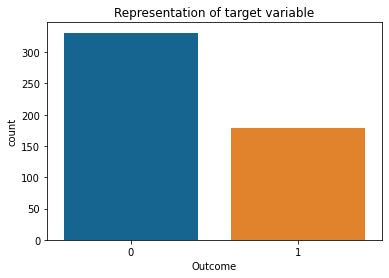

In [ ]:
# Visual representation of target variable
sns.countplot(x=df_train.Outcome).set_title("Representation of target variable");

We see the classes can not be considered as balanced and therefore it might help to apply a suitable balancing method. In this case we will use the `RandomOverSampler()` from the `imblearn` package. 

In [ ]:
# Oversample training data
ros = RandomOverSampler(random_state=42)
X_train_scaled_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)

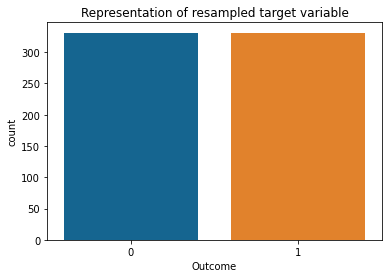

In [ ]:
# Visual representation of resampled target variable
sns.countplot(x=y_train_ros).set_title("Representation of resampled target variable");

## Model building and testing

Before we start modelling we should think about which **metric** is most appropriate for our case. As we are considering diabetes test results we want to identify all patients that indeed have this disease to avoid any (further) damage or complications.

**Therefore, we go for recall (remember, $\text{Recall}=\frac{TP}{TP + FN}$) on the one hand.**

Since we don't want to ignore the precision completely, we can find a compromise by having another look on the **fbeta score with a higher weight for recall.**

In [ ]:
# Define fbeta score with higher weighted recall
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# Define dictionary with several interesting metrics
scorer_dict = {"ftwo_scorer": make_scorer(fbeta_score, beta=2), "accuracy": "accuracy", "precision": "precision", "recall": "recall"}

### Baseline Model

Before we start training our first model, we should define a proper baseline model. This baseline model represents a educated guess and acts as a benchmark for any further models to beat. From the exploration of our data we can see that the glucose value is a good indicator if someone has diabetes or not. We will choose a value of 130 as the cutoff. For our baseline model we will predict that everyone with a glucose value higher than 130 suffers from diabetes. 

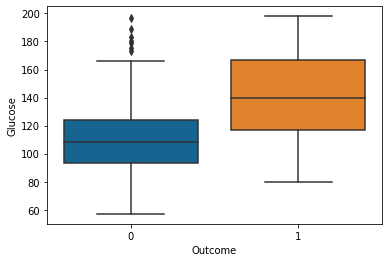

In [ ]:
# Glucose value for both outcomes
sns.boxplot(x=df_train.Outcome, y=df_train.Glucose);

In [ ]:
# Defining baseline model
def baseline_model(df):
    y_pred = [1 if x > 130 else 0 for x in df.Glucose]
    return y_pred

In [ ]:
# Make predictions 
y_pred = baseline_model(X_test)

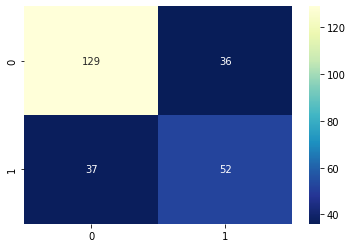

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

In [ ]:
print("Fbeta score with higher weighted recall: ", fbeta_score(df_test.Outcome, y_pred, beta=2).round(3))

Fbeta score with higher weighted recall:  0.586


In [ ]:
print(classification_report(df_test.Outcome, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       165
           1       0.59      0.58      0.59        89

    accuracy                           0.71       254
   macro avg       0.68      0.68      0.68       254
weighted avg       0.71      0.71      0.71       254



Our baseline model reaches a accuracy of 71% and what is even more important a **recall of 58%**. That is the value we have to beat with our more sophisticated models.

### Predictive Modeling

After we got our benchmark via the baseline model, we can now test different model types to figure out which ones can handle our data. We will pick the two most promising ones for further fine tuning of the hyperparameters. 

In [ ]:
def model_evaluation(clf, scoring, X_train, y_train):
    
    results = {}
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
    results = {key: [value.mean().round(4), value.std().round(4)] for key, value in scores.items()}
    
    del results['fit_time']
    del results['score_time']
    
    return results

In [ ]:
# Test different types of models
list_of_clf = [LogisticRegression(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(random_state=42)]

for clf in list_of_clf:
    #results = model_evaluation(clf, ['accuracy', 'recall', 'precision', scorer_dict['ftwo_scorer']], X_train_scaled, y_train)
    results = model_evaluation(clf, scorer_dict, X_train_scaled_ros, y_train_ros)
    print(clf)
    print("Accuracy  (mean, std):", results["test_accuracy"])
    print("Recall    (mean, std):", results["test_recall"])
    print("Precision (mean, std):", results["test_precision"])
    print("Fbeta     (mean, std):", results["test_ftwo_scorer"])
    print("----"*10)

LogisticRegression()
Accuracy  (mean, std): [0.7478, 0.0361]
Recall    (mean, std): [0.7127, 0.0593]
Precision (mean, std): [0.7675, 0.0424]
Fbeta     (mean, std): [0.7222, 0.0508]
----------------------------------------
KNeighborsClassifier()
Accuracy  (mean, std): [0.7886, 0.0385]
Recall    (mean, std): [0.8339, 0.0476]
Precision (mean, std): [0.7663, 0.043]
Fbeta     (mean, std): [0.8188, 0.0404]
----------------------------------------
SVC()
Accuracy  (mean, std): [0.7751, 0.0536]
Recall    (mean, std): [0.7914, 0.0395]
Precision (mean, std): [0.7698, 0.0647]
Fbeta     (mean, std): [0.7864, 0.0408]
----------------------------------------
DecisionTreeClassifier(random_state=42)
Accuracy  (mean, std): [0.8068, 0.0577]
Recall    (mean, std): [0.8613, 0.1169]
Precision (mean, std): [0.7768, 0.0372]
Fbeta     (mean, std): [0.8407, 0.0929]
----------------------------------------


If we compare the metrics of the trained models above, we can see that the decision tree performs rather good, followed by KNN.

#### Hyperparameter Tuning of Decision Tree

In [ ]:
# Define param grid
param_grid = {'criterion':  ['gini', 'entropy'],
              'max_depth': np.arange(5,70,5),
              'min_samples_split': np.arange(5,30, 5)}

# Passing model, parametergrid and 5-fold cross validation to GridSearchCV
dec_tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1, scoring=ftwo_scorer)

# Fitting GridSearchCV will output all parameters passed
dec_tree_gs.fit(X_train_scaled_ros, y_train_ros)

Fitting 5 folds for each of 130 candidates, totalling 650 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25])},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [ ]:
# Returning best score (recall) after GridSearch and parameter combination
print("                Best score:", dec_tree_gs.best_score_.round(4))
print("Best parameter combination:", dec_tree_gs.best_params_)
dec_tree_best = dec_tree_gs.best_estimator_

                Best score: 0.8352
Best parameter combination: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5}


#### Hyperparameter Tuning of KNN

In [ ]:
# In case of knn the parameters to be tuned are n_neighbors and the distance metric p
param_grid = {'n_neighbors': np.arange(2,50),
             'p': [1, 2]}

# Passing model, parametergrid and 5-fold cross validation to GridSearchCV
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1, scoring=ftwo_scorer)

# Fitting GridSearchCV 
knn_gs.fit(X_train_scaled_ros, y_train_ros)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'p': [1, 2]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [ ]:
# Returning best score (recall) after GridSearch and parameter combination
print("                Best score:", knn_gs.best_score_.round(4))
print("Best parameter combination:", knn_gs.best_params_)
knn_best = knn_gs.best_estimator_

                Best score: 0.8205
Best parameter combination: {'n_neighbors': 7, 'p': 1}


### Model Evaluation

#### Decison Tree

Decision trees tend to overfit the data and this can be clearly seen here! We have nearly perfect scores on our train data, but on the test data the performance is remarkably worse. One option would be to further regularize the model, or we can try to combat overfitting by using an ensemble model which is based on decision trees (e.g. Random Forest).

Decision Tree on train data
fbeta score: 0.9818
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       331
           1       0.99      0.98      0.99       331

    accuracy                           0.99       662
   macro avg       0.99      0.99      0.99       662
weighted avg       0.99      0.99      0.99       662

------------------------------------------------------------


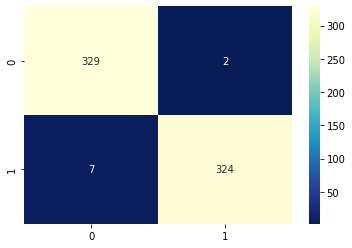

In [ ]:
# Plot confusion matrix and classification report for best knn model
y_train_pred_dt = dec_tree_best.predict(X_train_scaled_ros)

print("Decision Tree on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_train_ros, y_train_pred_dt, beta=2).round(4))
print("---"*20)
print(classification_report(y_train_ros, y_train_pred_dt))
print("---"*20)

cm = confusion_matrix(y_train_ros, y_train_pred_dt)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

Decision Tree on test data
fbeta score: 0.5928
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       165
           1       0.58      0.60      0.59        89

    accuracy                           0.71       254
   macro avg       0.68      0.68      0.68       254
weighted avg       0.71      0.71      0.71       254

------------------------------------------------------------


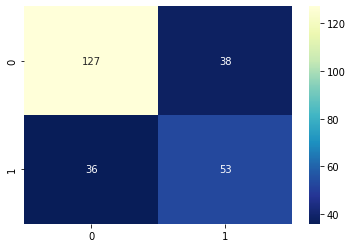

In [ ]:
# Plot confusion matrix and classification report for best knn model
y_test_pred_dt = dec_tree_best.predict(X_test_scaled)

print("Decision Tree on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_pred_dt, beta=2).round(4))
print("---"*20)
print(classification_report(y_test, y_test_pred_dt))
print("---"*20)

cm = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

#### Model Evaluation

##### KNN

Our KNN model is also slightly overfitting. That is one of the issues one might encounter when balancing the data with oversampling. But it is still performing better on the test set than the decision tree and it is also beating the benchmark from our baseline model!

KNN on train data
fbeta score: 0.8498
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       331
           1       0.82      0.86      0.84       331

    accuracy                           0.83       662
   macro avg       0.83      0.83      0.83       662
weighted avg       0.83      0.83      0.83       662

------------------------------------------------------------


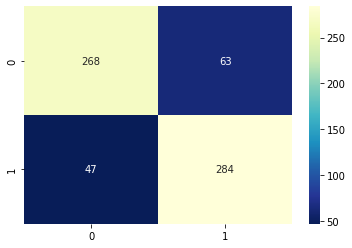

In [ ]:
# Plot confusion matrix and classification report for best knn model
y_train_pred_knn = knn_best.predict(X_train_scaled_ros)

print("KNN on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_train_ros, y_train_pred_knn, beta=2).round(4))
print("---"*20)
print(classification_report(y_train_ros, y_train_pred_knn))
print("---"*20)

cm = confusion_matrix(y_train_ros, y_train_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

KNN on test data
fbeta score: 0.6848
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       165
           1       0.61      0.71      0.65        89

    accuracy                           0.74       254
   macro avg       0.72      0.73      0.72       254
weighted avg       0.75      0.74      0.74       254

------------------------------------------------------------


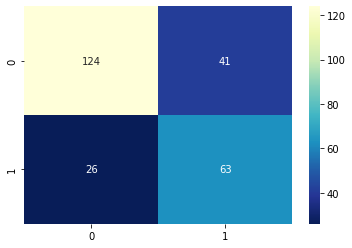

In [ ]:
# Plot confusion matrix and classification report for best knn model
y_test_pred_knn = knn_best.predict(X_test_scaled)

print("KNN on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_pred_knn, beta=2).round(4))
print("---"*20)
print(classification_report(y_test, y_test_pred_knn))
print("---"*20)

cm = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Error analysis

Let's see where our KNN model has problems differentiating between the classes.

In [ ]:
correct = []
for pred, true in zip(y_test_pred_knn, y_test):
    if pred == true and pred==1:
        correct.append("TP")
    if pred == true and pred==0:
        correct.append("TN")
    if pred != true and pred==1:
        correct.append("FP")
    if pred != true and pred==0:
        correct.append("FN")

df_test["correct"] = correct
df_test.head(2)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome,correct
373,2,105.0,58.0,34.9,0.225,25,0,TN
164,0,131.0,88.0,31.6,0.743,32,1,FN


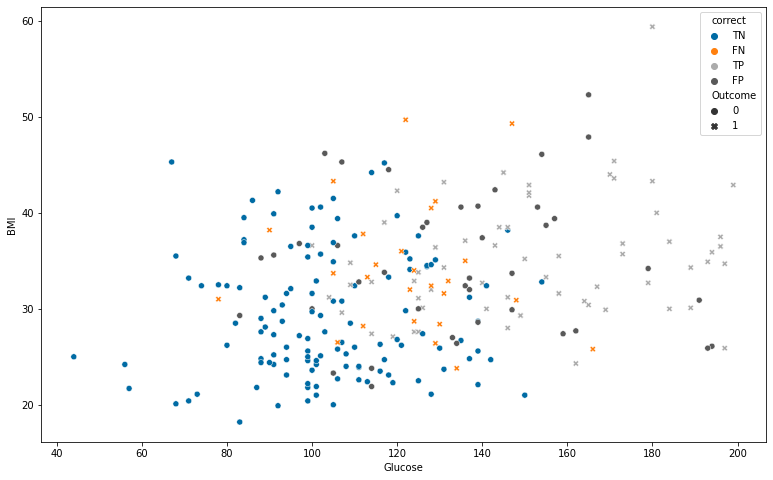

In [ ]:
# Create exemplary scatterplot for two features
plt.subplots(figsize=(13,8))
sns.scatterplot(data=df_test, x="Glucose", y="BMI", hue="correct", style="Outcome");

From a plot like the one above we can try to draw some conclusions:
- people with too high glucose concentration in blood will generally be predicted as diabetes patients (even if they are not (FP))
- people with relatively low BMIs and Glucose levels will usually be predicted as healthy

Of course the outcome depends on more than those features. We could also have a closer look at other feature combinations to see if we can find patterns.